In [33]:
import pandas as pd
import os, re 
import matplotlib.pyplot as plt 
import numpy as np 
import torch 
import seaborn as sns 

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from sklearn.decomposition import PCA
from numpy.linalg import svd 

#PERMANOVA on SV1/SV2 sample projections of data 
from scipy.spatial import distance_matrix
from skbio.stats import distance as sk_distance 

import matplotlib
matplotlib.rc('font', family='sans-serif') 
matplotlib.rc('font', serif='Helvetica Neue') 
matplotlib.rc('text', usetex='false') 

csv_dir = "csv"

In [34]:
# DE_LRT_dir = "DE/output/DE_LRT_E6_floored"
# DE_LRT_dir = "DE/output/DE_LRT_edgeR_filt_E6nf_BHwhole"
DE_LRT_dir = "DE/output/DE_LRT_edgeR_filt_E6nf"
param_str = re.search(r'DE\/output\/DE_LRT_([\w_]+)',DE_LRT_dir).groups()[0]
print(param_str)
# DE_LRT_dir = "DE/output/DE_LRT_E6"
DE_strains = ["Mmu","Dlo","Rob","Bbr","Bca","Lru","Eav","Eco","Lga4B6","Rgn","Rto","Sga","Spa"]

# PARAM_STR = "thr3_prev0.25_cecal_nonprevotella_E6"
# fp_tables_dir = "formatted_output/4th_trial/fp_tables/abundance_corrected/{0}".format(PARAM_STR)
fp_tables_dir = "formatted_output/4th_trial/fp_tables/edgeR_filtered"

fp_pht_fpath = "{0}/fp_pht_mcseed.csv".format(fp_tables_dir)
fp_tr_fpath = "{0}/fp_tr_mcseed.csv".format(fp_tables_dir)
fp_pht_mcseed = pd.read_csv(fp_pht_fpath,index_col=0)
fp_tr_mcseed = pd.read_csv(fp_tr_fpath,index_col=0)
fp_pht_mcseed.index.name = "strain_phenotype"
fp_tr_mcseed.index.name = "target_id"

figures_dir = "DE/figures"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

edgeR_filt_E6nf


In [38]:
STRAIN_ABBREVS = ["Bbr","Bca","Bli2D9","Blu","Rob","Dfo","Dlo","Eav","Eco","FprB","Lga4B6","Lru","Mmu","Pco","Pst",
                  "Rgn","Rto","Sga","Spa"]
CAZYME_STRAIN_ABBREVS = ["Bbr","Bca","Bli2D9","Bli463","Blu","Bwe","Dfo","Dlo","Eav","Eco","FprB","Lga4B6","Mmu","Pco","Pst",
                  "Rgn","Rob","Rto","Sga","Spa"]
STRAIN_TAXA_NAMES = ["B. breve","B. catenulatum","B. longum infantis 2D9","B. luti","B. obeum","D. formicigenerans",
                     "D. longicatena","E. avium","E. coli","F. prausnitzii","L. garvieae","L. ruminis",
                     "M. multacida","P. copri","P. stercorea","R. gnavus","R. torques","S. gallolyticus","S. pasteurianus"]

In [40]:
#mcSEED Data import#
input_dir = "formatted_input"
mcseed_path = "{0}/19isolates_mcseed_pathwaycomplete.csv".format(input_dir)

mcseed_df = pd.read_csv(mcseed_path)
mcseed_df.set_index("Locus tag",inplace=True)
# display(mcseed_list_phts)

pht_pathway_df = pd.DataFrame(columns=["Functional pathway","Functional category"])
for pht_str in mcseed_df["Phenotype"].unique():
    pht_str_matches = mcseed_df.loc[mcseed_df["Phenotype"]==pht_str]
    assert(len(pht_str_matches["Functional pathway"].unique())==1)
    functional_pathway = pht_str_matches.iloc[0]["Functional pathway"]
    functional_category = pht_str_matches.iloc[0]["Functional category"]
    split_phts = [pht.strip() for pht in pht_str.split(";")]
    split_paths = [cat.strip().title() for cat in functional_pathway.split(";")]
    for pht, cat in zip(split_phts,split_paths):
        pht_pathway_df.loc[pht,"Functional pathway"] = cat
    if len(functional_category.split(";")) == 1:
        pht_pathway_df.loc[split_phts,"Functional category"] = functional_category
        
# display(pht_pathway_df)
mcseed_df.loc[:,"Strain"] = mcseed_df.loc[:,"Isolate name"].map(dict(zip(mcseed_df["Isolate name"].unique(),                                                       STRAIN_ABBREVS)))
display(mcseed_df)

cazyme_fpath = "{0}/CAZyme_annotation_summary.txt".format(input_dir)
cazyme_df = pd.read_csv(cazyme_fpath,sep='\t',names=["Isolate","Locus", "Description", "ModelNotes", "Definition"])
cazyme_df.loc[:,"Strain"] = cazyme_df.loc[:,"Isolate"].map(
    dict(zip(cazyme_df["Isolate"].unique(),CAZYME_STRAIN_ABBREVS)))
display(cazyme_df)

,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain
Locus tag,,,,,,,
ANCJAENF_00011,Bifidobacterium breve Bgsng463_m5_93,MalE,"Maltose/maltodextrin ABC transporter, substrat...",Carbohydrate utilization,maltose utilization; maltooligosaccharides uti...,Mal; (Mal)n,Bbr
ANCJAENF_00013,Bifidobacterium breve Bgsng463_m5_93,MalF,"Maltose/maltodextrin ABC transporter, permease...",Carbohydrate utilization,maltose utilization; maltooligosaccharides uti...,Mal; (Mal)n,Bbr
ANCJAENF_00014,Bifidobacterium breve Bgsng463_m5_93,MalG,"Maltose/maltodextrin ABC transporter, permease...",Carbohydrate utilization,maltose utilization; maltooligosaccharides uti...,Mal; (Mal)n,Bbr
ANCJAENF_00052,Bifidobacterium breve Bgsng463_m5_93,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,galactose utilization; lactose utilization,Gal; Lac,Bbr
ANCJAENF_00063,Bifidobacterium breve Bgsng463_m5_93,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,galactose utilization; lactose utilization,Gal; Lac,Bbr
...,...,...,...,...,...,...,...
LDOIJNDB_02225,Streptococcus pasteriuanus Bang_SAM2_39_S1,TreB_c,"PTS system, trehalose-specific IIC component (...",Carbohydrate utilization,trehalose utilization,Tre,Spa
LDOIJNDB_02226,Streptococcus pasteriuanus Bang_SAM2_39_S1,TreB_b,"PTS system, trehalose-specific IIB component (...",Carbohydrate utilization,trehalose utilization,Tre,Spa
LDOIJNDB_02245,Streptococcus pasteriuanus Bang_SAM2_39_S1,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,galactose utilization; lactose utilization,Gal; Lac,Spa


,Isolate,Locus,Description,ModelNotes,Definition,Strain
0,bifidobacterium_breve_bgsng463_m5_93,ANCJAENF_00037,GH43,fragment N-term;,Glycoside Hydrolase Family 43 protein,Bbr
1,bifidobacterium_breve_bgsng463_m5_93,ANCJAENF_00038,GH43_22,fragment N-term / C-term;,Glycoside Hydrolase Family 43 protein,Bbr
2,bifidobacterium_breve_bgsng463_m5_93,ANCJAENF_00049,GH25,NaN,Glycoside Hydrolase Family 25 protein,Bbr
3,bifidobacterium_breve_bgsng463_m5_93,ANCJAENF_00055,GT2,NaN,Glycosyltransferase Family 2 protein,Bbr
4,bifidobacterium_breve_bgsng463_m5_93,ANCJAENF_00073,GT2,NaN,Glycosyltransferase Family 2 protein,Bbr
...,...,...,...,...,...,...
1748,streptococcus_pasteurianus_bang_sam2_39,LDOIJNDB_02115,GH38,NaN,Glycoside Hydrolase Family 38 protein,Spa
1749,streptococcus_pasteurianus_bang_sam2_39,LDOIJNDB_02123,GT2,NaN,Glycosyltransferase Family 2 protein,Spa
1750,streptococcus_pasteurianus_bang_sam2_39,LDOIJNDB_02125,GT4,NaN,Glycosyltransferase Family 4 protein,Spa
1751,streptococcus_pasteurianus_bang_sam2_39,LDOIJNDB_02126,GT2,NaN,Glycosyltransferase Family 2 protein,Spa


In [116]:
# display(mcseed_df.loc[mcseed_df["Strain"]=="Mmu"])
gsea_input_dir = "~/mstp/Gordon/experiments/MG00_HWDC_og/HOSVD/DE/gsea_input"
multiple_pht_loci = mcseed_df.loc[mcseed_df["Phenotype"].str.contains(";")]
single_pht_loci = mcseed_df.loc[~mcseed_df["Phenotype"].str.contains(";")]
# display(single_pht_loci)
assert(sum(single_pht_loci["Phenotype"].str.contains(";"))==0)
# display(multiple_pht_loci)
multiple_pht_duplicated = pd.DataFrame(columns=multiple_pht_loci.columns)
for locus_tag,row in multiple_pht_loci.iterrows():
#     if locus_tag in ["ANCJAENF_00011","ANCJAENF_00013"]:
    n_phts = len(row["Phenotype"].split(";"))
    duplicated = pd.DataFrame(data=[row]*n_phts)
    duplicated.loc[:,"Functional pathway"] = [fp.strip() for fp in row["Functional pathway"].split(";")]
    duplicated.loc[:,"Phenotype"] = [pht.strip() for pht in row["Phenotype"].split(";")]
    multiple_pht_duplicated = pd.concat((multiple_pht_duplicated,duplicated))
multiple_pht_duplicated_outpath = "{0}/mcSEED_single_pht.csv".format(gsea_input_dir)
multiple_pht_duplicated.index.name = "Locus tag"
all_mcseed_with_duplicated = pd.concat((single_pht_loci,multiple_pht_duplicated))
all_mcseed_with_duplicated.sort_values(by=["Strain","Locus tag"],inplace=True)
display(all_mcseed_with_duplicated)
all_mcseed_with_duplicated.to_csv(multiple_pht_duplicated_outpath)
        

,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype,Strain
Locus tag,,,,,,,
ANCJAENF_00011,Bifidobacterium breve Bgsng463_m5_93,MalE,"Maltose/maltodextrin ABC transporter, substrat...",Carbohydrate utilization,maltose utilization,Mal,Bbr
ANCJAENF_00011,Bifidobacterium breve Bgsng463_m5_93,MalE,"Maltose/maltodextrin ABC transporter, substrat...",Carbohydrate utilization,maltooligosaccharides utilization,(Mal)n,Bbr
ANCJAENF_00013,Bifidobacterium breve Bgsng463_m5_93,MalF,"Maltose/maltodextrin ABC transporter, permease...",Carbohydrate utilization,maltose utilization,Mal,Bbr
ANCJAENF_00013,Bifidobacterium breve Bgsng463_m5_93,MalF,"Maltose/maltodextrin ABC transporter, permease...",Carbohydrate utilization,maltooligosaccharides utilization,(Mal)n,Bbr
ANCJAENF_00014,Bifidobacterium breve Bgsng463_m5_93,MalG,"Maltose/maltodextrin ABC transporter, permease...",Carbohydrate utilization,maltose utilization,Mal,Bbr
...,...,...,...,...,...,...,...
LDOIJNDB_02226,Streptococcus pasteriuanus Bang_SAM2_39_S1,TreB_b,"PTS system, trehalose-specific IIB component (...",Carbohydrate utilization,trehalose utilization,Tre,Spa
LDOIJNDB_02245,Streptococcus pasteriuanus Bang_SAM2_39_S1,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,galactose utilization,Gal,Spa
LDOIJNDB_02245,Streptococcus pasteriuanus Bang_SAM2_39_S1,GalE,UDP-glucose 4-epimerase (EC 5.1.3.2),Carbohydrate utilization,lactose utilization,Lac,Spa


,logFC,logCPM,LR,PValue,FDR,Strain
target_id,,,,,,
HIAFFLEM_02293,11.494661,9.936517,1.467695e+02,8.812895e-34,1.789018e-30,Rob
HIAFFLEM_00711,12.167089,10.676415,1.432560e+02,5.167357e-33,5.244867e-30,Rob
HIAFFLEM_00732,11.903892,10.298014,1.420780e+02,9.350108e-33,5.340755e-30,Rob
HIAFFLEM_02540,11.952564,10.446467,1.418432e+02,1.052365e-32,5.340755e-30,Rob
HIAFFLEM_01218,12.140588,10.777334,1.390670e+02,4.258270e-32,1.372739e-29,Rob
...,...,...,...,...,...,...
HMLHAAEP_00968,0.000605,5.325400,9.271103e-06,9.975706e-01,9.984464e-01,Eco
HMLHAAEP_01558,0.000621,5.110691,5.491039e-06,9.981303e-01,9.987874e-01,Eco
HMLHAAEP_00679,0.000282,6.411129,2.317284e-06,9.987854e-01,9.990821e-01,Eco


ValueError: Could not interpret input 'Phenotype'

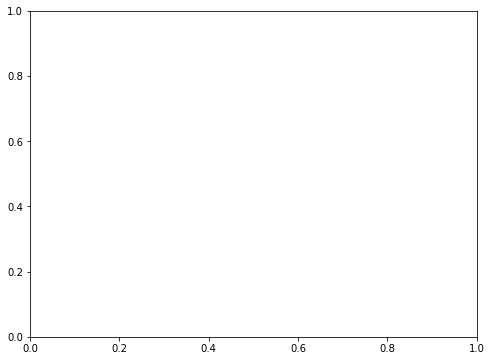

In [89]:
def read_DE_df(DE_LRT_dir,strain,dataset_type='all',tissue='cecal',comparison_str='p1Cn2B'):
    """
    Read in corresponding strain and differential expression dataset from DE_LRT_dir
    @param DE_LRT_dir: path to parent directory containing 
    @param strain: appropriate strain 3 letter abbreviation from STRAIN_ABBREVS
    @param dataset_type: ['all', 'bpm', 'bpm_sig']
    """
    DE_LRT_fpath = "{0}/{1}_{2}_{3}_{4}.csv".format(DE_LRT_dir,strain,tissue,comparison_str,dataset_type)
    DE_LRT_df = pd.read_csv(DE_LRT_fpath,index_col=0)
    DE_LRT_df.index.name = "target_id"
    return DE_LRT_df

def read_all_DE_dfs(DE_LRT_dir,strains,dataset_type='all',tissue='cecal'):
    """
    Read all DE_LRT_dfs from DE_LRT_dir corresponding to strains
    @param DE_LRT_dir: str; fpath 
    @param strains: 
    @return LRT_dfs: dictionary mapping strains in strain to corresponding single bacteria DE_LRT_df 
    @return all_LRT_results_df: concatenated individual strain DataFrames corresponding to dataset_type and tissue
    """
    all_LRT_results_df = pd.DataFrame()
    LRT_dfs = {}
    for strain in strains:
        DE_LRT_all_df = read_DE_df(DE_LRT_dir,strain,dataset_type=dataset_type,tissue=tissue)
        DE_LRT_all_df.loc[:,"Strain"] = strain
        LRT_dfs[strain] = DE_LRT_all_df
        all_LRT_results_df = pd.concat([all_LRT_results_df,DE_LRT_all_df])
    return LRT_dfs, all_LRT_results_df 

def strain_phenotypes_LRT_df(LRT_dfs,strains,strain_phts,include_filler_rows=False):
    DE_pht_df = pd.DataFrame(columns=["logFC","logCPM","LR","PValue","FDR","Strain","Phenotype","Category"])
    for strain in strains:
        for pht in strain_phts:
            LRT_df = LRT_dfs[strain]
            filt_mcseed = mcseed_df.loc[(mcseed_df["Strain"]==strain) & (mcseed_df["Phenotype"].str.contains(pht))]
            #filter mcseed down to LRT_df (ie remove genes removed by edgeR filterByExpr) 
            filt_mcseed = filt_mcseed.loc[filt_mcseed.index.isin(LRT_df.index)] 
            #filter LRT_strain_pht using above BPM and strain criteria 
            LRT_strain_pht = LRT_df.loc[filt_mcseed.index,:]
            #add in strain and phenotype information for DE_pht_df 
            n_LRT = len(LRT_strain_pht)
            LRT_strain_pht.loc[:,"Strain"] = [strain]*n_LRT
            LRT_strain_pht.loc[:,"Phenotype"] = [pht]*n_LRT
            if "|" in pht:
                pht_pathway_query = re.search(r'(\w+)\|[\w|]+',pht).groups()[0]
            else: 
                pht_pathway_query = pht
            LRT_strain_pht.loc[:,"Category"] = [pht_pathway_df.loc[pht_pathway_query,"Functional category"]]*n_LRT
            if include_filler_rows and len(filt_mcseed) == 0:
                filler_vals = [np.nan,np.nan,np.nan,np.nan,np.nan,strain,pht,pht_pathway_df.loc[pht_pathway_query,"Functional category"]]
                filler_row = pd.Series(dict(zip(DE_pht_with_filler.columns,filler_vals)),name="filler_{0}_{1}".format(pht,strain))
                DE_pht_df.loc[filler_row.name,:] = filler_row
            else:
                DE_pht_df = pd.concat([DE_pht_df,LRT_strain_pht])
    DE_pht_df.loc[:,"Significant"] = DE_pht_df.loc[:,"FDR"] < 0.05
    return DE_pht_df

def DE_pht_df_significant_split(DE_pht_df,strains,strain_phts,insert_fillers=False):
    DE_pht_df.loc[:,"Pht_Hue"] = DE_pht_df.loc[:,"Phenotype"].apply(lambda pht: strain_phts.index(pht)) 
    DE_sig_df = DE_pht_df.loc[(DE_pht_df["Significant"]) | (DE_pht_df.index.str.contains("filler")),:]
    DE_ns_df = DE_pht_df.loc[(~DE_pht_df["Significant"]) | (DE_pht_df.index.str.contains("filler")),:]
    
    #Insert filler strains; useful if using sig and ns dfs for plotting to ensure x-axis alignment for seaborn
    if insert_fillers and len(DE_sig_df["Strain"].unique()) != len(DE_ns_df["Strain"].unique()):
        DE_sig_with_filler = pd.DataFrame(columns=DE_sig_df.columns)
        DE_ns_with_filler = pd.DataFrame(columns=DE_ns_df.columns)
        for strain in strains: 
            DE_sig_with_filler = pd.concat([DE_sig_with_filler,DE_sig_df.loc[DE_sig_df["Strain"]==strain]])
            DE_ns_with_filler = pd.concat([DE_ns_with_filler,DE_ns_df.loc[DE_ns_df["Strain"]==strain]])
            if len(DE_sig_df.loc[DE_sig_df["Strain"]==strain]) == 0:
                sig_filler_vals =  [np.nan,np.nan,np.nan,np.nan,np.nan,strain,strain_phts[0],"",True,0]
                DE_sig_with_filler = pd.concat([DE_sig_with_filler,
                                              pd.DataFrame(index=[strain+"_filler"],columns=DE_sig_df.columns,
                                                          data=dict(zip(DE_sig_df.columns,sig_filler_vals)))])
            if len(DE_ns_df.loc[DE_ns_df["Strain"]==strain]) == 0: 
                ns_filler_vals =  [np.nan,np.nan,np.nan,np.nan,np.nan,strain,strain_phts[0],"",False,0]
                DE_ns_with_filler = pd.concat([DE_ns_with_filler,
                                              pd.DataFrame(index=[strain+"_filler"],columns=DE_ns_df.columns,
                                                          data=dict(zip(DE_ns_df.columns,ns_filler_vals)))])
        return DE_sig_with_filler, DE_ns_with_filler
    else:
        return DE_LRT_sig_df,DE_ns_df

def logFC_hlines_vlines(ax,plot_vlines=True):
    #hlines and vlines 
    ymin,ymax = ax.get_ylim()
    xmin,xmax = ax.get_xlim()
    if plot_vlines: #For separators between strain labels or x-label groups
        vline_pos = [x + 0.5 for x in ax.get_xticks()]
        vline_pos = vline_pos[:-1]
        ax.vlines(vline_pos,ymin,ymax,color="#CCCCCC",linestyles='dashed',linewidths=0.75)
    ax.hlines(1,xmin,xmax,color="#CCCCCC",zorder=1,linestyles='dashed',linewidths=1) #logFC = 1 hline
    ax.set_xlim(xmin,xmax) #reset original x and y lims
    ax.set_ylim(ymin,ymax)
    
def violin_stripplot(strains,strain_phts,DE_LRT_dir,dataset_type='all',tissue='cecal',DE_stripplot_fpath=""):
    if len(strain_phts) <= 5: 
        strain_pht_sig_palette = {0:"#E69F00",1:"#D55E00",2:"#56B4E9",3:"#0072B2",4:"#009E73"}
        strain_pht_ns_palette = {0:"#999999",1:"#999999",2:"#999999",3:"#999999",4:"#999999"}
    #needs DE_LRT_dir, mcseed_df, figures_dir, param_str
    LRT_dfs, all_LRT_results_df = read_all_DE_dfs(DE_LRT_dir,strains,dataset_type=dataset_type,
                                                  tissue=tissue)
    display(all_LRT_results_df["Strain"].value_counts())
    DE_pht_df = strain_phenotypes_LRT_df(LRT_dfs,strains,strain_phts,include_filler_rows=True)
    DE_sig_df,DE_ns_df = DE_pht_df_significant_split(DE_pht_df,strains,strain_phts,insert_fillers=True)
    
    #Figure generation, then violin and stripplot calls 
    fig,ax = plt.subplots(1,1,figsize=(8,6))
    #Use all_LRT_results (ie all LRT results for dataset_type) for violin plot 
    sns.violinplot(data=all_LRT_results_df,x="Strain",y="logFC",color="#DDDDDD",zorder=1,scale="count",inner=None,
                  linewidth=1)
    sns.stripplot(data=DE_sig_df,x="Strain",y="logFC",hue="Pht_Hue",palette=strain_pht_sig_palette, dodge=True,
                  zorder=3,alpha=0.9)
    sns.stripplot(data=DE_ns_df,x="Strain",y="logFC",hue="Pht_Hue",palette=strain_pht_ns_palette, dodge=True,zorder=2,alpha=0.9)
    #Style adjustments - Legend including all significant color palettes and one dot for N.S. color palette 
    handles, labels = ax.get_legend_handles_labels()
    handles = handles[:len(strain_phts)+1]
    ax.legend(handles,strain_phts+["NS"])
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
    #hline and vline defaults (separate strains with vlines, hline at y = 1)
    logFC_hlines_vlines(ax,plot_vlines=True)

    ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(),rotation=45,ha='right')
    plt.savefig(DE_stripplot_fpath,dpi=300,facecolor="w",bbox_inches="tight")
    
def strain_pht_stripplot(strains,strain_phts,dataset_type='all',tissue='cecal',DE_stripplot_fpath="",
                        plot_violin_dist=True):
    if len(strains) <= 4: 
        AX_four_hue_light = ["#7EE6D9","#78BBF5","#677DCC","#D991FF"]
        AX_four_hue_dark = ["#0B9E8D","#0464B3","#190C91","#7D109E"]
    #needs DE_LRT_dir, mcseed_df, figures_dir, param_str
    LRT_dfs, all_LRT_results_df = read_all_DE_dfs(DE_LRT_dir,strains,dataset_type=dataset_type,
                                                  tissue=tissue)
    display(all_LRT_results_df)
    DE_pht_df = strain_phenotypes_LRT_df(LRT_dfs,strains,strain_phts,include_filler_rows=True)
    DE_sig_df,DE_ns_df = DE_pht_df_significant_split(DE_pht_df,strains,strain_phts,insert_fillers=True)
    #Plot generation
    fig,ax = plt.subplots(1,1,figsize=(8,6))
    if plot_violin_dist:
        sns.violinplot(data=all_LRT_results_df,x="Phenotype",y="logFC",hue="Strain",palette=AX_four_hue_light,
                       zorder=1,scale="count",inner=None,linewidth=0,alpha=0.5)
    sns.stripplot(data=DE_sig_df,x="Phenotype",y="logFC",hue="Strain",palette=AX_four_hue_dark, dodge=True,zorder=2)
    sns.stripplot(data=DE_ns_df,x="Phenotype",y="logFC",hue="Strain",palette=AX_four_hue_light, dodge=True,zorder=1)

#     handles, labels = ax.get_legend_handles_labels()
#     # new_labels = [val for val in ("{0} N.S.".format(strain),"{0} Significant".format(strain)) for strain in AX_strains]
#     new_label_pairs = [("{0} N.S.".format(strain),"{0} Significant".format(strain)) for strain in AX_strains]
#     new_labels = [item for pair in new_label_pairs for item in pair]
#     ax.legend(handles,new_labels)
    handles,labels = ax.get_legend_handles_labels()
    new_labels = [strain+" q<0.05" for strain in strains] + [strain +" N.S." for strain in strains]
    
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

#     ymin,ymax = ax.get_ylim()
#     XTICK_GROUP_SIZE = 4
#     all_sp_xticks = ax.get_xticks()
#     grouped_xticks = []
#     for i in range(len(all_sp_xticks)//XTICK_GROUP_SIZE):
#         i_group_xticks = all_sp_xticks[i*XTICK_GROUP_SIZE:(i+1)*XTICK_GROUP_SIZE]
#         avg_xtick = np.mean(i_group_xticks)
#         grouped_xticks.append(avg_xtick)
#         vline_xpos = [i_group_xticks[0]-0.5,i_group_xticks[-1] + 0.5]
#         ax.vlines(vline_xpos,ymin,ymax,linestyles='dashed',colors="#BBBBBB")
#         ax.set_ylim(ymin,ymax)
#     ax.set_xlim(all_sp_xticks[0]-0.5,all_sp_xticks[-1]+0.5)
#     ax.set_xticks(grouped_xticks,strain_phts)

#     ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(),rotation=45,ha='right')
#     DE_stripplot_fpath = "{0}/{1}_pht_strain_AX_GlBCAA.pdf".format(figures_dir,param_str)
#     plt.savefig(DE_stripplot_fpath,dpi=300,facecolor="w",bbox_inches="tight")

strain_pht_stripplot(AX_strains,strain_phts,dataset_type='all',tissue='cecal')

Eco    4560
Rob    2030
Bca    1409
Mmu    1265
Name: Strain, dtype: int64

Eco    4560
Rob    2030
Bca    1409
Mmu    1265
Name: Strain, dtype: int64

Eco    4560
Rob    2030
Bca    1409
Mmu    1265
Name: Strain, dtype: int64

Eco    5040
Eav    1295
Spa     953
Bbr     103
Name: Strain, dtype: int64

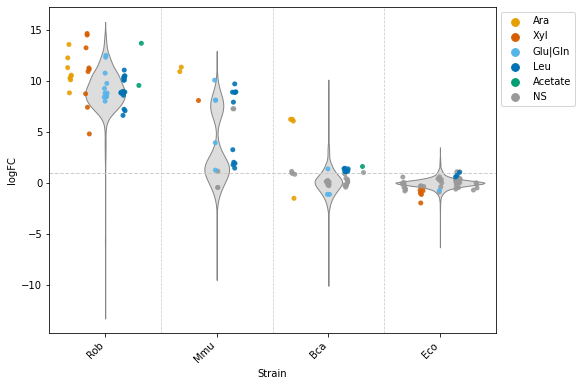

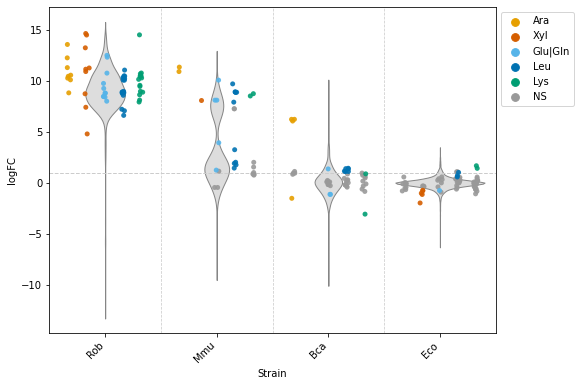

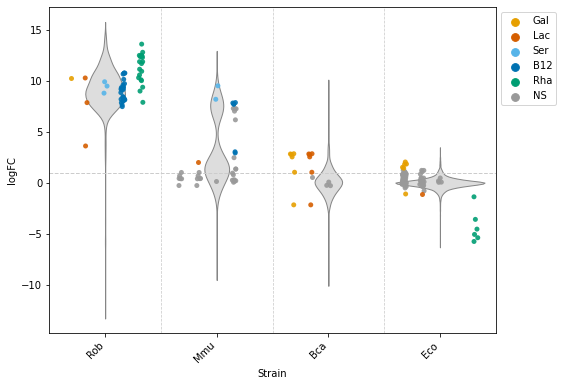

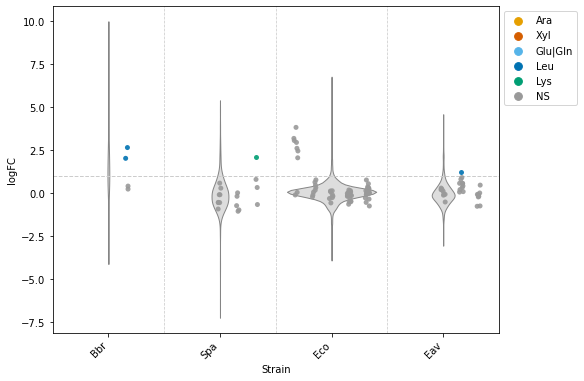

In [120]:
#Cecal violin plot 
AX_strains = ["Rob","Mmu","Bca","Eco"]
strain_phts = ["Ara","Xyl","Glu|Gln","Leu","Acetate"]
DE_stripplot_fpath = "{0}/{1}_violin_strip.pdf".format(figures_dir,param_str)
cecal_DE_LRT_dir = "DE/output/DE_LRT_edgeR_filt_E6nf"
violin_stripplot(AX_strains,strain_phts,cecal_DE_LRT_dir,dataset_type='all',tissue='cecal',DE_stripplot_fpath=DE_stripplot_fpath)

AX_strains = ["Rob","Mmu","Bca","Eco"]
strain_phts = ["Ara","Xyl","Glu|Gln","Leu","Lys"]
DE_stripplot_fpath = "{0}/{1}_violin_strip_Lys.pdf".format(figures_dir,param_str)
cecal_DE_LRT_dir = "DE/output/DE_LRT_edgeR_filt_E6nf"
violin_stripplot(AX_strains,strain_phts,cecal_DE_LRT_dir,dataset_type='all',tissue='cecal',DE_stripplot_fpath=DE_stripplot_fpath)

#GSEA highlighted phenotypes
AX_strains = ["Rob","Mmu","Bca","Eco"]
gsea_strain_phts = ["Gal","Lac","Ser","B12","Rha"]
DE_stripplot_fpath = "{0}/{1}_violin_strip_gsea_phts.pdf".format(figures_dir,param_str)
violin_stripplot(AX_strains,gsea_strain_phts,cecal_DE_LRT_dir,dataset_type='all',tissue='cecal',DE_stripplot_fpath=DE_stripplot_fpath)


#Ileal violin plot 
ileal_strains = ["Bbr","Spa","Eco","Eav"]
ileal_DE_LRT_dir = "DE/output/DE_LRT_ileal"
ileal_DE_stripplot_fpath = "{0}/ileal_violin_strip.pdf".format(figures_dir,param_str)
violin_stripplot(ileal_strains,strain_phts,ileal_DE_LRT_dir,dataset_type='all',tissue='ileal',DE_stripplot_fpath=ileal_DE_stripplot_fpath)

In [46]:

# for strain in ["Mmu"]: #DE_strains: 
#     DE_LRT_all_df = read_DE_df(DE_LRT_dir,strain,dataset_type='all',tissue='cecal')
#     DE_LRT_sig_df = read_DE_df(DE_LRT_dir,strain,dataset_type='bpm_sig',tissue='cecal')
#     strain_filtered_fp_tr = fp_tr_mcseed.loc[fp_tr_mcseed["Strain abbreviation"]==strain]
#     for pht in Mmu_phts: 
#         pht_filtered_fp_tr = strain_filtered_fp_tr.loc[strain_filtered_fp_tr["Phenotype"].str.contains(pht)]
#         pht_tr_idx = pht_filtered_fp_tr.index
#         print("==={0} {1}===".format(strain,pht))
#         display(DE_LRT_all_df.loc[pht_tr_idx,:])
    

{0: '#7EE6D9', 1: '#0B9E8D', 2: '#78BBF5', 3: '#0464B3', 4: '#677DCC', 5: '#190C91', 6: '#D991FF', 7: '#7D109E'}


,logFC,logCPM,LR,PValue,FDR,Strain,Phenotype,Category,Significant,Pht_Strain,Strain_Sig_Hue
HIAFFLEM_01073,8.825741,7.691647,37.436662,0.0,0.0,Rob,Ara,Carbohydrate utilization,True,Ara_Rob,1
HIAFFLEM_02452,13.56359,12.359367,63.878357,0.0,0.0,Rob,Ara,Carbohydrate utilization,True,Ara_Rob,1
HIAFFLEM_02453,10.264802,9.224107,34.972507,0.0,0.0,Rob,Ara,Carbohydrate utilization,True,Ara_Rob,1
HIAFFLEM_02454,10.099736,9.075792,28.620854,0.0,0.0,Rob,Ara,Carbohydrate utilization,True,Ara_Rob,1
HIAFFLEM_02455,10.449305,9.330487,32.447582,0.0,0.0,Rob,Ara,Carbohydrate utilization,True,Ara_Rob,1
...,...,...,...,...,...,...,...,...,...,...,...
HMLHAAEP_00596,-0.686021,8.15356,2.301515,0.129248,0.475061,Eco,Acetate|Propionate,Fermentation products,False,Acetate|Propionate_Eco,6
HMLHAAEP_01703,-0.485841,4.043547,2.053689,0.151838,0.514581,Eco,Acetate|Propionate,Fermentation products,False,Acetate|Propionate_Eco,6
HMLHAAEP_01703,-0.485841,4.043547,2.053689,0.151838,0.514581,Eco,Acetate|Propionate,Fermentation products,False,Acetate|Propionate_Eco,6
HMLHAAEP_04469,-0.121114,9.682334,0.325157,0.568525,0.873474,Eco,Acetate|Propionate,Fermentation products,False,Acetate|Propionate_Eco,6


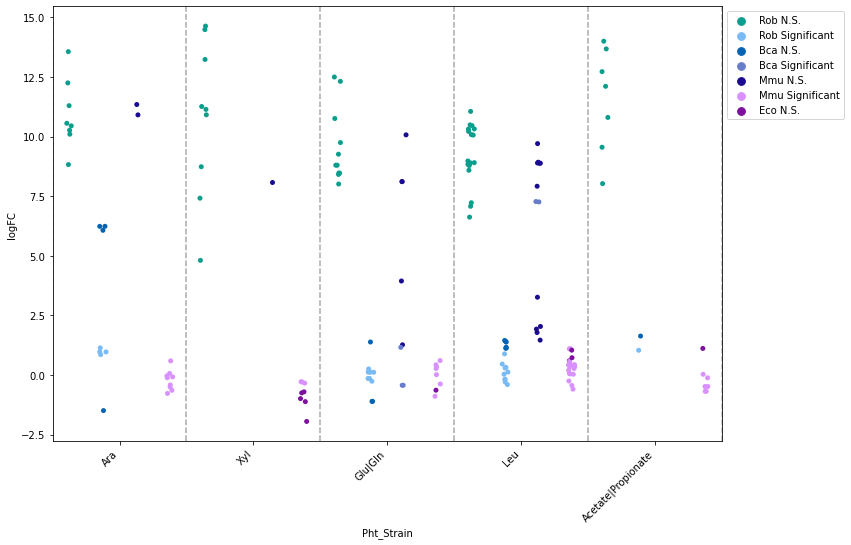

In [6]:
#combined 4strain version - phenotype then strain groups (strains as hue)
AX_four_hue_light = ["#7EE6D9","#78BBF5","#677DCC","#D991FF"]
# AX_four_hue_dark = ["#12E6B9","#0589F5","#2310CC","#CB19FF"]
AX_four_hue_dark = ["#0B9E8D","#0464B3","#190C91","#7D109E"]

AX_alternating_eight_hue = [val for pair in zip(AX_four_hue_light, AX_four_hue_dark) for val in pair]
AX_alternating_palette = dict(zip(range(len(AX_alternating_eight_hue)),AX_alternating_eight_hue))
print(AX_alternating_palette)

AX_strains = ["Rob","Bca","Mmu","Eco"]
AX_LRT_dfs = {}
#Read DE dataframes
for strain in AX_strains:
    DE_LRT_all_fpath = "{0}/{1}_cecal_p1Cn2B_all.csv".format(DE_LRT_dir,strain)
    DE_LRT_all_df = read_DE_df(DE_LRT_dir,strain,tissue='cecal',dataset_type='all')
    AX_LRT_dfs[strain] = DE_LRT_all_df
    
    
    
DE_pht_df = pd.DataFrame(columns=["logFC","logCPM","LR","PValue","FDR","Strain","Phenotype","Category"])
DE_pht_with_filler = pd.DataFrame(columns=["logFC","logCPM","LR","PValue","FDR","Strain","Phenotype","Category"])
# strain_phts = ["Ara","Xyl","Glu|Gln","Leu","Pro|His|Arg", "Acetate", "Propionate"] #including Pro|His|Arg
strain_phts = ["Ara","Xyl","Glu|Gln","Leu","Acetate|Propionate"]
#Iterate over phenotypes, then strains 
for pht in strain_phts:
    for strain in AX_strains:
# for strain in AX_strains:
#     for pht in strain_phts:
        strain_filtered_fp_tr = fp_tr_mcseed.loc[fp_tr_mcseed["Strain abbreviation"]==strain]
        LRT_df = AX_LRT_dfs[strain]
        
        pht_filtered_fp_tr = strain_filtered_fp_tr.loc[strain_filtered_fp_tr["Phenotype"].str.contains(pht)]
        
        pht_tr_idx = pht_filtered_fp_tr.index
        LRT_strain_pht = LRT_df.loc[pht_tr_idx,:]
        n_LRT = len(LRT_strain_pht)
        
        LRT_strain_pht.loc[:,"Strain"] = [strain]*n_LRT
        LRT_strain_pht.loc[:,"Phenotype"] = [pht]*n_LRT
        if "|" in pht:
            pht_pathway_query = re.search(r'(\w+)\|[\w|]+',pht).groups()[0]
        else: 
            pht_pathway_query = pht
#             LRT_strain_pht.loc[:,"Category"] = [pht_pathway_df.loc[pht,"Functional category"]]*n_LRT
        LRT_strain_pht.loc[:,"Category"] = [pht_pathway_df.loc[pht_pathway_query,"Functional category"]]*n_LRT
        DE_pht_df = pd.concat([DE_pht_df,LRT_strain_pht])
        if len(pht_filtered_fp_tr) > 0:
            DE_pht_with_filler = pd.concat([DE_pht_with_filler,LRT_strain_pht])
        else:
            filler_vals = [np.nan,np.nan,np.nan,np.nan,np.nan,strain,pht,pht_pathway_df.loc[pht_pathway_query,"Functional category"]]
            filler_row = pd.Series(dict(zip(DE_pht_with_filler.columns,filler_vals)),name="filler_{0}_{1}".format(pht,strain))
#             display(filler_row)
#             DE_pht_with_filler = pd.concat([DE_pht_with_filler,filler_row],axis=1)
            DE_pht_with_filler.loc[filler_row.name,:] = filler_row
            
DE_pht_df = DE_pht_with_filler #For visualization purposes (ie with spacer strain-phenotype combinations)

DE_pht_df.loc[:,"Significant"] = DE_pht_df.loc[:,"FDR"] < 0.05
DE_pht_df.loc[:,"Pht_Strain"] = DE_pht_df.loc[:,"Phenotype"] + "_" + DE_pht_df.loc[:,"Strain"]
DE_pht_df.loc[:,"Strain_Sig_Hue"] = 2*DE_pht_df.loc[:,"Strain"].apply(lambda x: AX_strains.index(x)) + \
                                    DE_pht_df.loc[:,"Significant"].astype(int)
# for col in ["Significant","Pht_Strain","Strain_Sig_Hue"]:
#     DE_pht_with_filler.loc[DE_pht_df.index,col] = DE_pht_df.loc[DE_pht_df.index,col]

display(DE_pht_with_filler)

fig,ax = plt.subplots(1,1,figsize=(12,8))
sns.stripplot(data=DE_pht_df,x="Pht_Strain",y="logFC",hue="Strain_Sig_Hue",palette=AX_alternating_palette, dodge=False)
# sns.stripplot(data=DE_pht_df,x="Phenotype",y="logFC",hue="Strain_Sig_Hue",palette=AX_alternating_palette, dodge=True)
handles, labels = ax.get_legend_handles_labels()
# new_labels = [val for val in ("{0} N.S.".format(strain),"{0} Significant".format(strain)) for strain in AX_strains]
new_label_pairs = [("{0} N.S.".format(strain),"{0} Significant".format(strain)) for strain in AX_strains]
new_labels = [item for pair in new_label_pairs for item in pair]
ax.legend(handles,new_labels)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

ymin,ymax = ax.get_ylim()
XTICK_GROUP_SIZE = 4
all_sp_xticks = ax.get_xticks()
grouped_xticks = []
for i in range(len(all_sp_xticks)//XTICK_GROUP_SIZE):
    i_group_xticks = all_sp_xticks[i*XTICK_GROUP_SIZE:(i+1)*XTICK_GROUP_SIZE]
    avg_xtick = np.mean(i_group_xticks)
    grouped_xticks.append(avg_xtick)
    vline_xpos = [i_group_xticks[0]-0.5,i_group_xticks[-1] + 0.5]
    ax.vlines(vline_xpos,ymin,ymax,linestyles='dashed',colors="#BBBBBB")
    ax.set_ylim(ymin,ymax)
ax.set_xlim(all_sp_xticks[0]-0.5,all_sp_xticks[-1]+0.5)
ax.set_xticks(grouped_xticks,strain_phts)
    
ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(),rotation=45,ha='right')
DE_stripplot_fpath = "{0}/{1}_pht_strain_AX_GlBCAA.pdf".format(figures_dir,param_str)
plt.savefig(DE_stripplot_fpath,dpi=300,facecolor="w",bbox_inches="tight")
        

In [45]:
pht_match = "Ara|Xyl|Glu|Gln|Leu|Ile|Val|Acetate|Propionate"

for strain in AX_strains:
    DE_LRT_sig_df = read_DE_df(DE_LRT_dir,strain,dataset_type='bpm_sig',tissue='cecal')
    


    DE_mcseed_join = DE_LRT_sig_df.join(fp_tr_mcseed,how='inner')#["Protein product","Functional category","Phenotype"],how='inner')
    print("==={0}===".format(strain))
#     display(DE_mcseed_join["Phenotype"].value_counts())
    with pd.option_context('display.max_rows',None):
        pass
#         display(DE_mcseed_join.loc[DE_mcseed_join["Phenotype"].str.contains(pht_match),:].sort_values("logFC",ascending=False)) #select phts only
#         display(DE_mcseed_join.sort_values("logFC",ascending=False)) #all results
    
#     fig,ax = plt.subplots(1,1,figsize=(6,6))
#     sns.histplot(AX_LRT_dfs[strain]["logFC"])
#     plt.title(strain)


===Rob===
===Mmu===
===Bca===
===Eco===


,1C,2B,Diff_1C2B
Mmu,5.889643,3.460928,2.428716
Dlo,6.608873,5.47975,1.129123
Rob,6.366475,3.433965,2.93251
Bbr,6.180464,4.799861,1.380603
Bca,6.801363,5.246255,1.555108
Lru,5.252512,3.39112,1.861391
Eav,6.117874,6.828658,-0.710784
Eco,7.323772,7.715724,-0.391953
Lga4B6,5.584979,5.23864,0.346339
Rgn,6.627611,7.608585,-0.980974


,Mmu,Dlo,Rob,Bbr,Bca,Lru,Eav,Eco,Lga4B6,Rgn,Rto,Sga,Spa
MouseID,,,,,,,,,,,,,
Pup_1-cecal_contents_53_1C_Pup_1,5.361892,6.190280,6.170294,5.960476,6.250244,4.708580,5.840627,7.330020,5.621041,6.510134,6.080361,5.531280,5.920522
Pup_2-cecal_contents_53_1C_Pup_2,5.153064,6.380181,5.870585,5.332027,6.040396,4.330766,5.790704,7.070037,5.292222,6.460151,5.581141,5.441574,5.830642
Pup_3-cecal_contents_53_1C_Pup_3,5.920522,6.620104,6.280228,6.220262,6.890056,5.680906,6.010424,7.170029,5.391766,6.520131,5.950487,5.581141,6.200274
Pup_4-cecal_contents_53_1C_Pup_4,6.020415,6.560120,6.360190,6.280228,6.940050,5.531280,6.100345,7.310021,5.611065,6.480144,5.870585,5.511340,6.160300
Pup_5-cecal_contents_53_1C_Pup_5,6.330203,6.620104,6.720083,6.440158,7.100034,5.700866,6.190280,7.330020,5.650971,6.510134,5.920522,4.349853,6.230256
Pup_6-cecal_contents_53_1C_Pup_6,6.280228,6.920052,6.380181,6.660095,7.300022,5.890559,6.420165,7.460015,5.910534,6.700087,5.940498,4.836377,6.610107
Pup_7-cecal_contents_53_1C_Pup_7,5.990444,6.730081,6.700087,6.340198,6.960048,5.053854,6.240250,7.330020,5.501371,6.930051,6.200274,5.272326,6.540125
Pup_8-cecal_contents_53_1C_Pup_8,6.060378,6.850061,6.450154,6.210268,6.930051,5.123282,6.350194,7.590011,5.700866,6.910053,6.590112,5.401726,6.850061
Pup_1-cecal_contents_54_2B_Pup_1,3.463215,6.890056,3.889908,5.351936,6.200274,3.483122,6.980045,7.940005,6.120329,7.660010,6.730081,4.757655,6.960048


,Abundance,DE All Fraction,DE BPM Fraction
Strain,,,
Bbr,1.380603,0.012161,0.005291
Sga,1.239734,0.115385,0.05
Dlo,1.129123,0.035409,0.059233
Rto,0.861571,0.183333,0.101796
Lga4B6,0.346339,0.087117,0.125
Eco,-0.391953,0.068421,0.128458
Spa,-0.214639,0.1,0.18595
Rgn,-0.980974,0.126313,0.186192
Bca,1.555108,0.25692,0.285714


BPM Sig Fraction: 0.28426892950391647
All Sig Fraction: 0.22762366460184935


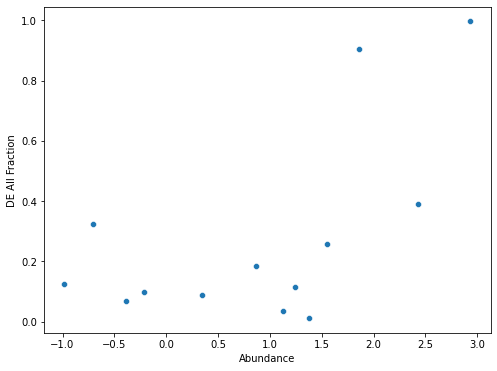

In [92]:
#DE Fraction vs Abundance Difference Analysis 

cecal_abundance_fpath = "DE/input/thr3_prev0.25_cecal_nonprevotella_E6/cecal_abundance_E6.csv"
cecal_abundance_df = pd.read_csv(cecal_abundance_fpath,index_col=0)
# display(cecal_abundance_df)
cecal_abundance_diff = pd.DataFrame(index=DE_strains,columns=["1C","2B","Diff_1C2B"])
cecal_abundance_full = pd.DataFrame(index=cecal_abundance_df.index,columns=DE_strains)
for strain in DE_strains:
    strain_col = cecal_abundance_df[strain]
    strain_col = np.log10(strain_col*10**6+10**3)
    #Convert absolute abundance back to log10
    strain_1C, strain_2B = strain_col[strain_col.index.str.contains("1C")],\
                            strain_col[strain_col.index.str.contains("2B")]
    mean_1C, mean_2B = strain_1C.mean(), strain_2B.mean()
    diff_1C2B = mean_1C-mean_2B
    cecal_abundance_diff.loc[strain,:] = [mean_1C,mean_2B,diff_1C2B]
    cecal_abundance_full.loc[:,strain] = strain_col
display(cecal_abundance_diff)
display(cecal_abundance_full)

    
total_all = 0
total_all_sig = 0
total_BPM_sig = 0
total_BPM = 0 
abundance_DE_df = pd.DataFrame(index=DE_strains,columns=["Abundance","DE All Fraction","DE BPM Fraction"])
for strain in DE_strains: 
    DE_LRT_all_fpath = "{0}/{1}_cecal_p1Cn2B_all.csv".format(DE_LRT_dir,strain)
    DE_LRT_bpm_fpath = "{0}/{1}_cecal_p1Cn2B_bpm.csv".format(DE_LRT_dir,strain)
    DE_LRT_sig_fpath = "{0}/{1}_cecal_p1Cn2B_bpm_sig.csv".format(DE_LRT_dir,strain)
    DE_LRT_all_df = pd.read_csv(DE_LRT_all_fpath,index_col=0)
    DE_LRT_bpm_df = pd.read_csv(DE_LRT_bpm_fpath,index_col=0)
    DE_LRT_sig_df = pd.read_csv(DE_LRT_sig_fpath,index_col=0)
    DE_LRT_all_df.index.name = "target_id"
    DE_LRT_bpm_df.index.name = "target_id"
    DE_LRT_sig_df.index.name = "target_id"
    sig_fraction = len(DE_LRT_sig_df)/len(DE_LRT_bpm_df)
    all_sig_fraction = len(DE_LRT_all_df[DE_LRT_all_df["FDR"]<0.05])/len(DE_LRT_all_df)
#     print("{0}: {1}".format(strain,sig_fraction))
#     print("all genes sig fraction: {1}".format(strain,all_sig_fraction))
    total_BPM += len(DE_LRT_bpm_df)
    total_BPM_sig += len(DE_LRT_sig_df)
    total_all += len(DE_LRT_all_df)
    total_all_sig += len(DE_LRT_all_df[DE_LRT_all_df["FDR"]<0.05])
    
    abundance_DE_df.loc[strain,:] = [cecal_abundance_diff.loc[strain,"Diff_1C2B"],all_sig_fraction,sig_fraction]
abundance_DE_df.index.name = "Strain"
display(abundance_DE_df.sort_values("DE BPM Fraction"))
fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.scatterplot(data=abundance_DE_df,x="Abundance",y="DE All Fraction")#,hue="Strain")
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))
# print("Total BPM Genes: {0}".format(total_BPM))
# print("Total BPM Sig Genes: {0}".format(total_BPM_sig))
print("BPM Sig Fraction:",total_BPM_sig/total_BPM)
print("All Sig Fraction:",total_all_sig/total_all)



array([0.01216089803554724, 0.03540903540903541, 0.06842105263157895,
       0.08711656441717791, 0.1, 0.11538461538461539, 0.1263126312631263,
       0.18333333333333332, 0.25691980127750175, 0.323540780827213,
       0.3897233201581028, 0.905982905982906, 0.996551724137931],
      dtype=object)

['Bbr (1.22%)', 'Dlo (3.54%)', 'Eco (6.84%)', 'Lga4B6 (8.71%)', 'Spa (10.00%)', 'Sga (11.54%)', 'Rgn (12.63%)', 'Rto (18.33%)', 'Bca (25.69%)', 'Eav (32.35%)', 'Mmu (38.97%)', 'Lru (90.60%)', 'Rob (99.66%)']


[Text(0, 0, 'Bbr (1.22%)'),
 Text(0, 1, 'Dlo (3.54%)'),
 Text(0, 2, 'Eco (6.84%)'),
 Text(0, 3, 'Lga4B6 (8.71%)'),
 Text(0, 4, 'Spa (10.00%)'),
 Text(0, 5, 'Sga (11.54%)'),
 Text(0, 6, 'Rgn (12.63%)'),
 Text(0, 7, 'Rto (18.33%)'),
 Text(0, 8, 'Bca (25.69%)'),
 Text(0, 9, 'Eav (32.35%)'),
 Text(0, 10, 'Mmu (38.97%)'),
 Text(0, 11, 'Lru (90.60%)'),
 Text(0, 12, 'Rob (99.66%)')]

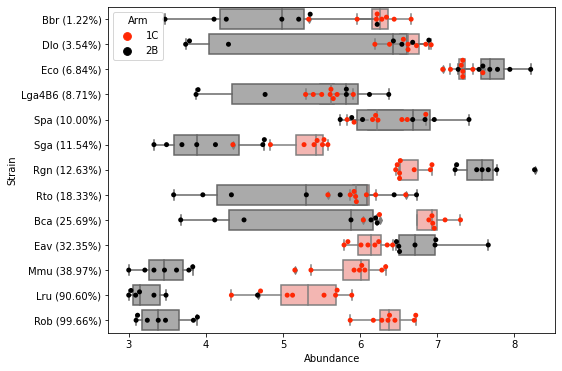

In [11]:
# display(cecal_abundance_full)
cecal_abundance_long = pd.DataFrame(columns=["Sample","Abundance","Strain","Arm","DE All Fraction"])
for strain in cecal_abundance_full:
    short_df = pd.DataFrame(columns=cecal_abundance_long.columns)
    full_col = cecal_abundance_full.loc[:,strain]
    short_df.loc[:,"Sample"] = full_col.index
    short_df.loc[:,"Abundance"] = full_col.values
    short_df.loc[:,"Strain"] = [strain]*len(full_col)
    short_df.loc[:,"Arm"] = full_col.index.str.extract(r'Pup_\d-cecal_contents_\d+_([\w]+)_Pup_\d',expand=True)[0]
    short_df.loc[:,"DE All Fraction"] = [abundance_DE_df.loc[strain,"DE All Fraction"]]*len(full_col)
    cecal_abundance_long = pd.concat((cecal_abundance_long,short_df))

cecal_abundance_long.sort_values("DE All Fraction",inplace=True)
display(cecal_abundance_long["DE All Fraction"].unique())
cecal_long_1C, cecal_long_2B = cecal_abundance_long.loc[cecal_abundance_long["Arm"]=="1C"],\
                                cecal_abundance_long.loc[cecal_abundance_long["Arm"]=="2B"]
HWDC_points_palette = ["#FF2804","#000000"]
HWDC_ellipses_palette = ["#FEACA7","#AAAAAA"]
DE_fraction_heatmap = sns.color_palette("crest", as_cmap=True)

fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.swarmplot(data=cecal_abundance_long,x="Abundance",y="Strain",hue="Arm",ax=ax,palette=HWDC_points_palette,zorder=2)
sns.boxplot(data=cecal_long_1C,x="Abundance",y="Strain",color=HWDC_ellipses_palette[0],zorder=1)#,hue="DE All Fraction",ax=ax,palette=sns.color_palette("crest", as_cmap=True),zorder=1)
sns.boxplot(data=cecal_long_2B,x="Abundance",y="Strain",color=HWDC_ellipses_palette[1],zorder=1)#,hue="DE All Fraction",ax=ax,palette=sns.color_palette("crest", as_cmap=True),zorder=1)

strain_DE_labels = [strain + " ({:.2%})".format(abundance_DE_df.loc[strain,"DE All Fraction"]) for strain in cecal_abundance_long["Strain"].unique()]
print(strain_DE_labels)
ax.set_yticklabels(strain_DE_labels)

In [12]:
##Ileal Violin Strip Plot
#combined 4strain version - strain first level, pathways as hue/subgroup

strain_pht_palette = {-1:"#BBBBBB",0:"#3B92CB",1:"#EE252C",2:"#1200FF",3:"#FF6F00",4:"#00B000"} #background/Ara/Xyl/Glu/BCAA/Acetate
# strain_pht_sig_palette = {0:"#3B92CB",1:"#EE252C",2:"#1200FF",3:"#FF6F00",4:"#00B000"} #5 color no grouping
# strain_pht_sig_palette = {0:"#FA5805",1:"#DE070C",2:"#0569FF",3:"#3C0BDE",4:"#D905F5"} #5 color carb red, aa blue, acetate pink - from Adobe Color swatch
strain_pht_sig_palette = {0:"#E69F00",1:"#D55E00",2:"#56B4E9",3:"#0072B2",4:"#009E73"} #color-blind accessible modified 5 color
# strain_pht_ns_palette = {0:"#BBBBBB",1:"#BBBBBB",2:"#BBBBBB",3:"#BBBBBB",4:"#BBBBBB"}
strain_pht_ns_palette = {0:"#999999",1:"#999999",2:"#999999",3:"#999999",4:"#999999"}
# strain_pht_ns_palette = {0:"#555555",1:"#555555",2:"#555555",3:"#555555",4:"#555555"} #Darker ns palette 

ileal_strains = ["Bbr","Spa","Bca","Eco","Eav"]
ileal_DE_LRT_dir = "DE/output/DE_LRT_ileal"
ileal_LRT_dfs = {}
#Read DE dataframes
all_LRT_results_df = pd.DataFrame()
for strain in ileal_strains:
    DE_LRT_all_fpath = "{0}/{1}_ileal_p1Cn2B_all.csv".format(ileal_DE_LRT_dir,strain)
    DE_LRT_all_df = pd.read_csv(DE_LRT_all_fpath,index_col=0)
    DE_LRT_all_df.index.name = "target_id"
    ileal_LRT_dfs[strain] = DE_LRT_all_df
    DE_LRT_all_df.loc[:,"Strain"] = strain
    all_LRT_results_df = pd.concat([all_LRT_results_df,DE_LRT_all_df])
    
display(all_LRT_results_df)
    
DE_pht_df = pd.DataFrame(columns=["logFC","logCPM","LR","PValue","FDR","Strain","Phenotype","Category"])
DE_pht_with_filler = pd.DataFrame(columns=["logFC","logCPM","LR","PValue","FDR","Strain","Phenotype","Category"])
strain_phts = ["Ara","Xyl","Glu|Gln","Leu","Acetate"]

for strain in ileal_strains:
    for pht in strain_phts:
        strain_filtered_fp_tr = fp_tr_mcseed.loc[fp_tr_mcseed["Strain abbreviation"]==strain]
        LRT_df = ileal_LRT_dfs[strain]
        pht_filtered_fp_tr = strain_filtered_fp_tr.loc[strain_filtered_fp_tr["Phenotype"].str.contains(pht)]
        pht_tr_idx = pht_filtered_fp_tr.index
        LRT_strain_pht = LRT_df.loc[pht_tr_idx,:]
        n_LRT = len(LRT_strain_pht)
        LRT_strain_pht.loc[:,"Strain"] = [strain]*n_LRT
        LRT_strain_pht.loc[:,"Phenotype"] = [pht]*n_LRT
        if "|" in pht:
            pht_pathway_query = re.search(r'(\w+)\|[\w|]+',pht).groups()[0]
        else: 
            pht_pathway_query = pht
#             LRT_strain_pht.loc[:,"Category"] = [pht_pathway_df.loc[pht,"Functional category"]]*n_LRT
        LRT_strain_pht.loc[:,"Category"] = [pht_pathway_df.loc[pht_pathway_query,"Functional category"]]*n_LRT
        DE_pht_df = pd.concat([DE_pht_df,LRT_strain_pht])
        if len(pht_filtered_fp_tr) > 0:
            DE_pht_with_filler = pd.concat([DE_pht_with_filler,LRT_strain_pht])
        else:
            filler_vals = [np.nan,np.nan,np.nan,np.nan,np.nan,strain,pht,pht_pathway_df.loc[pht_pathway_query,"Functional category"]]
            filler_row = pd.Series(dict(zip(DE_pht_with_filler.columns,filler_vals)),name="filler_{0}_{1}".format(pht,strain))
            DE_pht_with_filler.loc[filler_row.name,:] = filler_row
            
DE_pht_df = DE_pht_with_filler #For visualization purposes (ie with spacer strain-phenotype combinations)

DE_pht_df.loc[:,"Significant"] = DE_pht_df.loc[:,"FDR"] < 0.05
DE_pht_df.loc[:,"Pht_Hue"] = DE_pht_df.loc[:,"Phenotype"].apply(lambda pht: strain_phts.index(pht)) 
DE_sig_df = DE_pht_df.loc[(DE_pht_df["Significant"]) | (DE_pht_df.index.str.contains("filler")),:]
DE_ns_df = DE_pht_df.loc[(~DE_pht_df["Significant"]) | (DE_pht_df.index.str.contains("filler")),:]
#Prepend filler R. obeum filler row in ns df since no ns genes 
# rob_ns_filler_vals =  [np.nan,np.nan,np.nan,np.nan,np.nan,"Rob","Ara","Carbohydrate utilization",False,0]
# rob_ns_filler_row = pd.DataFrame(columns=DE_ns_df.columns)
# rob_ns_filler_row.loc["Rob_ns_filler",:] = rob_ns_filler_vals
# DE_ns_df = pd.concat((rob_ns_filler_row,DE_ns_df))
with pd.option_context('display.max_rows',None,'display.min_rows',None):

    pass


fig,ax = plt.subplots(1,1,figsize=(8,6))
sns.violinplot(data=all_LRT_results_df,x="Strain",y="logFC",color="#DDDDDD",zorder=1,scale="count",inner=None)
sns.stripplot(data=DE_sig_df,x="Strain",y="logFC",hue="Pht_Hue",palette=strain_pht_sig_palette, dodge=True,
              zorder=3,alpha=0.9)
sns.stripplot(data=DE_ns_df,x="Strain",y="logFC",hue="Pht_Hue",palette=strain_pht_ns_palette, dodge=True,zorder=2,alpha=0.9)


handles, labels = ax.get_legend_handles_labels()
handles = handles[:len(strain_phts)+1]
ax.legend(handles,strain_phts+["NS"])
sns.move_legend(ax, "upper left", bbox_to_anchor=(1,1))

ymin,ymax = ax.get_ylim()
xmin,xmax = ax.get_xlim()
vline_pos = [x + 0.5 for x in ax.get_xticks()]
vline_pos = vline_pos[:-1]
ax.vlines(vline_pos,ymin,ymax,color="#CCCCCC",linestyles='dashed',linewidths=1)
ax.hlines(1,xmin,xmax,color="#CCCCCC",zorder=1,linestyles='dashed',linewidths=1.5)
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)

    
ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(),rotation=45,ha='right')
DE_stripplot_fpath = "{0}/ileal_violin_strip.pdf".format(figures_dir,param_str)
plt.savefig(DE_stripplot_fpath,dpi=300,facecolor="w",bbox_inches="tight")
        

,logFC,logCPM,LR,PValue,FDR,Strain
target_id,,,,,,
ANCJAENF_00234,8.486659,8.819579,4.024857e+01,2.236194e-10,2.303280e-08,Bbr
ANCJAENF_00248,7.577899,7.982266,2.786861e+01,1.298392e-07,5.957678e-06,Bbr
ANCJAENF_00192,4.848339,8.549295,2.730764e+01,1.735246e-07,5.957678e-06,Bbr
ANCJAENF_01080,4.947428,8.449333,2.643318e+01,2.728131e-07,7.024936e-06,Bbr
ANCJAENF_00425,7.155981,7.836481,2.255070e+01,2.046700e-06,4.216203e-05,Bbr
...,...,...,...,...,...,...
AKLJOBCP_03188,-0.000837,8.590420,6.109685e-06,9.980278e-01,9.995562e-01,Eav
AKLJOBCP_02010,0.000826,8.028696,5.059271e-06,9.982053e-01,9.995562e-01,Eav
AKLJOBCP_03240,0.000742,7.092176,4.716777e-06,9.982671e-01,9.995562e-01,Eav


KeyError: "None of [Index(['ANCJAENF_01030', 'ANCJAENF_01031', 'ANCJAENF_01965', 'ANCJAENF_00644',\n       'ANCJAENF_01328', 'ANCJAENF_01724', 'ANCJAENF_01724', 'ANCJAENF_01725',\n       'ANCJAENF_01725', 'ANCJAENF_01726', 'ANCJAENF_01726'],\n      dtype='object', name='target_id')] are in the [index]"

In [219]:
ileal_LRT_dfs = {}
for strain in ileal_strains:
    DE_LRT_all_fpath = "{0}/{1}_ileal_p1Cn2B_bpm_sig.csv".format(ileal_DE_LRT_dir,strain)
    DE_LRT_bpm_sig_fpath = "{0}/{1}_ileal_p1Cn2B_bpm_sig.csv".format(ileal_DE_LRT_dir,strain)
    DE_LRT_all_df = pd.read_csv(DE_LRT_all_fpath,index_col=0)
    DE_LRT_all_df.index.name = "target_id"
    ileal_LRT_dfs[strain] = DE_LRT_all_df
    DE_LRT_all_df.loc[:,"Strain"] = strain
    all_LRT_results_df = pd.concat([all_LRT_results_df,DE_LRT_all_df])

display(mcseed_df.loc[ileal_LRT_dfs["Bbr"].index,:])


,Isolate name,Protein name,Protein product,Functional category,Functional pathway,Phenotype
target_id,,,,,,
ANCJAENF_00011,Bifidobacterium breve Bgsng463_m5_93,MalE,"Maltose/maltodextrin ABC transporter, substrat...",Carbohydrate utilization,maltose utilization; maltooligosaccharides uti...,Mal; (Mal)n
ANCJAENF_01922,Bifidobacterium breve Bgsng463_m5_93,GlgP,Glycogen phosphorylase (EC 2.4.1.1),Carbohydrate utilization,maltose utilization; maltooligosaccharides uti...,Mal; (Mal)n
ANCJAENF_01009,Bifidobacterium breve Bgsng463_m5_93,BSH,Choloylglycine hydrolase (EC 3.5.1.24),Other catabolic pathways,cholic acid deconjugation,CA_d
ANCJAENF_00649,Bifidobacterium breve Bgsng463_m5_93,LdhA-L,L-lactate dehydrogenase (EC 1.1.1.27),Fermentation products,L-lactate production,L-Lactate
ANCJAENF_01591,Bifidobacterium breve Bgsng463_m5_93,GosA,b(1-4)-linked galactooligosaccharides ABC tran...,Carbohydrate utilization,galactooligosaccharides utilization,GOS
ANCJAENF_00529,Bifidobacterium breve Bgsng463_m5_93,IlvD,Dihydroxy-acid dehydratase (EC 4.2.1.9),Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val
ANCJAENF_01863,Bifidobacterium breve Bgsng463_m5_93,IlvC; IlvC2,Ketol-acid reductoisomerase (NADP(+)) (EC 1.1....,Amino acids,isoleucine biosynthesis; leucine biosynthesis;...,Ile; Leu; Val
ANCJAENF_01196,Bifidobacterium breve Bgsng463_m5_93,AckA,Acetate kinase (EC 2.7.2.1),Fermentation products,acetate production,Acetate
ANCJAENF_00928,Bifidobacterium breve Bgsng463_m5_93,TrpC,Indole-3-glycerol phosphate synthase (EC 4.1.1...,Amino acids,tryptophan biosynthesis,Trp
